# Code Description
This code takes the large output of a parameter estimation project and then post-processes all of the data

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22

All parameter sets will be loaded in through the summary file associated with the result files

This code was initially written by Ryan Neff and then continued by Griffin Hampton (GSH) - Mirage Modi played a very important role in the multiprocessing of the data

# Import Packages

In [1]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
import colorsys
from tqdm import trange
from datetime import date
import pickle
import pandas as pd

# Options

In [2]:
#Data for the 20 and 100 SNR levels is stored in 15Dec22
#Data for the 50 and 500 SNR levels is stored in 05Jan23

data_folder = "SNR_100_BIC_filter_30May23"
analysis_file = "Post_Normalized_08Jun23"

# Define Parameters

In [3]:
with open('Intermediate_SimResults//hprParameter_info_' + data_date_oi + '.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    SNR_mat = dict['SNR_mat']
    n_noise_realizations = dict['n_noise_realizations']
    num_multistarts = dict['num_multistarts']
    lambdas = dict['lambdas']
    tdata = dict['tdata']
    c1_set = dict['c1_set']
    T21_set = dict['T21_set']
    T22_set = dict['T22_set']
    noise_date_oi = dict["noise_date_oi"]
    ob_weight = dict['ob_weight']
    upper_bound = dict['upper_bound']
    handle.close()

n_combos = len(c1_set)*len(T21_set)*len(T22_set)
print(f"There are {n_combos} parameter combos")
agg_weights = np.array([1, 1, 1/ob_weight, 1/ob_weight])

###################### Parameters Loop Through

param_name_list = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

There are 225 parameter combos


# Define General Functions

### Small Helper Functions

In [4]:
########################### Simple Functions ##############################
# Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def G_tilde_linear(T21, T22, lam):
    def G_linear(t, c1, c2):
        return np.append(G(t, c1, c2, T21, T22), [lam*c1, lam*c2])
    return G_linear

def construct_paramList(c1_list, T21_list, T22_list):
    preList = [item for item in itertools.product(c1_list, T21_list, T22_list)]
    postList = [list(elem) for elem in preList]
    [elem.insert(1,1-elem[0]) for elem in postList]
    return postList

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def aggregate(array):
    return np.sum(array*agg_weights**2, axis = -1)

def calc_improvement(old, new):
    return (old - new)/old

def post_normalize(object):
    initial_shape = object.shape
    stacked_params = np.reshape(object, (-1,4))
    scaled_params = np.ones(stacked_params.shape)*np.NAN
    coeficients = stacked_params[:,0]+stacked_params[:,1]
    scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
    scaled_params[:,2:] = stacked_params[:,2:]
    final_obj = np.reshape(scaled_params, initial_shape)
    return final_obj

def to_readable(file):
    df = pd.read_feather(file)
    ALL_ESTIMATES = np.stack(df["Estimates"].values) #shape: (index, noise_realization, lambda, popt)
    ALL_RES = np.stack(df["RSS"].values) #shape: (index, noise_realization, lambda, residual)
    ALL_PARAMS = np.stack(df["TrueParams"].values) #(index, 4)
    return ALL_PARAMS, ALL_ESTIMATES, ALL_RES

# Load Data Sets

In [ ]:
### DATA Set 1

with open(f'Intermediate_SimResults//{data_set1}.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    data_date_oi = dict['HyperParams']
    ds1_SNR_option = dict['SNR']
    post_normalized = dict['post_normalize_data']
    ds1_orcAvg_bias = dict['oracle_bias']
    ds1_orcAvg_var = dict['oracle_var']
    ds1_GCV_bias = dict['GCV_bias']
    ds1_GCV_var = dict['GCV_var']
    ds1_GCV_lambdas = dict['GCV_lambdas']
    ds1_GCV_final_params = dict['GCV_final_params']
    handle.close()

assert(post_normalized == post_normalized_opt)
assert(data_date_oi == central_date)


In [ ]:
### DATA Set 2

with open(f'Intermediate_SimResults//{data_set2}.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    data_date_oi = dict['HyperParams']
    ds2_SNR_option = dict['SNR']
    post_normalized = dict['post_normalize_data']
    ds2_orcAvg_bias = dict['oracle_bias']
    ds2_orcAvg_var = dict['oracle_var']
    ds2_GCV_bias = dict['GCV_bias']
    ds2_GCV_var = dict['GCV_var']
    ds2_GCV_lambdas = dict['GCV_lambdas']
    ds2_GCV_final_params = dict['GCV_final_params']
    handle.close()

assert(post_normalized == post_normalized_opt)
assert(data_date_oi == central_date)

# Calculate Improvement on All Cases

In [15]:


orcAvg_imp_MSE = calc_improvement(nonreg_MSE, minMSE_orcAvg_MSE)
orcAvg_imp_bias_sq = calc_improvement(nonreg_bias**2, minMSE_orcAvg_bias**2)
orcAvg_imp_var = calc_improvement(nonreg_var, minMSE_orcAvg_var)
orcAvg_agg_imp_MSE = calc_improvement(nonreg_agg_MSE, minMSE_orcAvg_agg_MSE)
orcAvg_agg_imp_bias_sq = calc_improvement(nonreg_agg_biasSq, minMSE_orcAvg_agg_bias_sq)
orcAvg_agg_imp_var = calc_improvement(nonreg_agg_var, minMSE_orcAvg_agg_var)


minErr_agg_imp_MSE = calc_improvement(nonreg_MSE, minErr_agg_MSE)
minErr_agg_imp_bias_sq = calc_improvement(nonreg_bias**2, minErr_agg_bias**2)
minErr_agg_imp_var = calc_improvement(nonreg_var, minErr_agg_var)

minErr_agg_imp_MSE_agg = calc_improvement(nonreg_agg_MSE, minErr_agg_MSE_agg)
minErr_agg_imp_bias_sq_agg = calc_improvement(nonreg_agg_biasSq, minErr_agg_bias_sq_agg)
minErr_agg_imp_var_agg = calc_improvement(nonreg_agg_var, minErr_agg_var_agg)

print('Orc 2 time:', (time.time()-start_time), ' seconds')



GCV_imp_MSE = calc_improvement(nonreg_MSE, GCV_MSE)
GCV_imp_bias_sq = calc_improvement(nonreg_bias**2, GCV_bias**2)
GCV_imp_var = calc_improvement(nonreg_var, GCV_var)
GCV_agg_imp_MSE = calc_improvement(nonreg_agg_MSE, GCV_agg_MSE)
GCV_agg_imp_bias_sq = calc_improvement(nonreg_agg_biasSq, GCV_agg_bias_sq)
GCV_agg_imp_var = calc_improvement(nonreg_agg_var, GCV_agg_var)

    print('GCV time:', (time.time()-start_time), ' seconds')


Calc avgNR bias and var: 1.3642208576202393  seconds
Orc 2 time: 1.1868584156036377  seconds


100%|██████████| 225/225 [11:02<00:00,  2.94s/it]

GCV time: 662.3741872310638  seconds


# Single Profile Selection

In [40]:
pCombo_oi = [0.4,0.6,50,70]
pC_index = paramCombos.index(pCombo_oi)

#single_pC is a single parameter combo that we are studying in detail
single_pC_GCV_MSE = GCV_MSE[pC_index,:]
single_pC_orcAvg = orcAvg_MSE[pC_index,:,:]
single_pC_orcAvg_min = np.min(single_pC_orcAvg, axis = 0)
single_pC_orcErr = minErr_agg_MSE[pC_index,:]
single_pC_nonReg = nonreg_MSE[pC_index,:]

CRLB_unbiased = cov_matrix(pCombo_oi[0], pCombo_oi[1], pCombo_oi[2], pCombo_oi[3], SNR_option)


#### All the necessary details to show the required biased CRLB measures in the graphs
#From Radu's Calculations Results (all c1 = 0.4) and (c2 = 0.6)
#SNR = 500 :: T21 = 40 :: T22 = 150
#       [0.000091, 0.000094, 1.359865, 3.169816]
#SNR = 20  :: T21 = 40 :: T22 = 150
#       [0.004086, 0.029010, 317.872198, 2297.748099]
#SNR = 500 :: T21 = 50 :: T22 = 70
#       [0.000561, 0.000509, 0.845960, 1.485598]
#SNR = 20  :: T21 = 50 :: T22 = 70
#       [0.014264, 0.030740, 124.268292, 2528.934997]

CRLB_biased = [0.000561, 0.000509, 0.845960, 1.485598]

#Identifying 
single_pC_orcAvg_agg = np.min(orcAvg_agg_MSE[pC_index,:])
single_pC_orcAvg_agg_lamb = lambdas[np.argmin(orcAvg_agg_MSE[pC_index,:])]
single_pC_orcAvg_agg_paramMSE = single_pC_orcAvg[np.argmin(orcAvg_agg_MSE[pC_index,:]), :]
print(f"Best regularization value = {single_pC_orcAvg_agg_lamb}")

Best regularization value = 0.039810717055349776


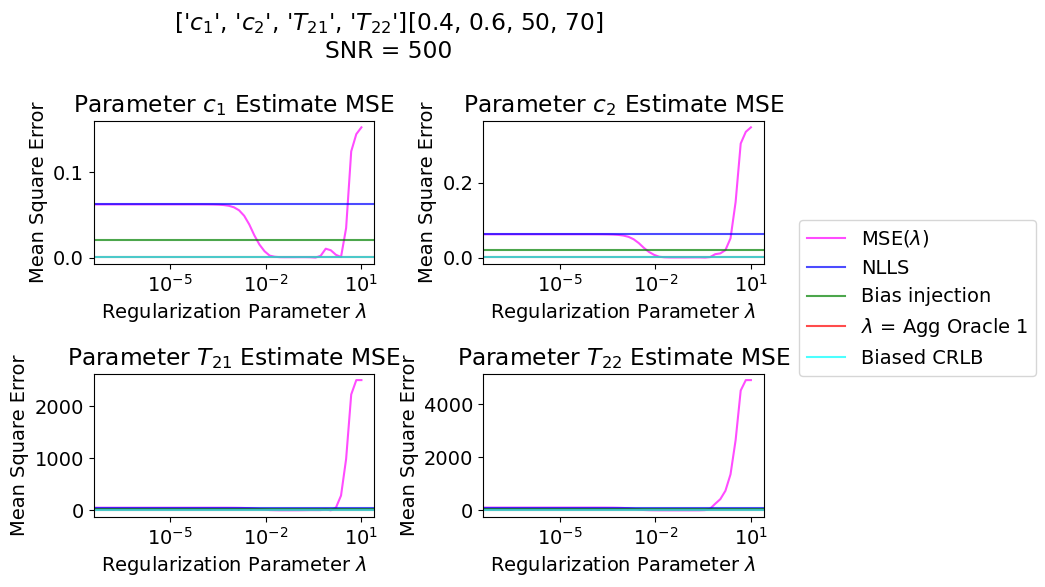

In [41]:


plt.rc('font', size = 14)
fig, ax = plt.subplots(2,2, figsize=(8,6), tight_layout=True)
fig.suptitle(str(param_name_list) + str(pCombo_oi) + '\nSNR = ' + str(SNR_option) + post_norm_blurb)
for i in range(4):
    ax[i//2, i%2].semilogx(lambdas, single_pC_orcAvg[:,i], label = r'MSE($\lambda$)', alpha = 0.7, color = "magenta")
    ax[i//2, i%2].axhline(y = single_pC_nonReg[i], label = r'NLLS', alpha = 0.7, color = "blue") #NLLS: $\lambda = 0$
    ax[i//2, i%2].axhline(y = single_pC_GCV_MSE[i], label = r'Bias injection', alpha = 0.7, color = "green") #$\lambda = GCV(\lambda)$
    # ax[i//2, i%2].axhline(y = single_pC_orcAvg_min[i], label = r'$\lambda$ = Oracle 1', alpha = 0.7, color = "red")
    ax[i//2, i%2].axhline(y = single_pC_orcAvg_agg_paramMSE[i], label = r'$\lambda$ = Agg Oracle 1', alpha = 0.7, color = "red")
    # ax[i//2, i%2].axhline(y = single_pC_orcErr[i], label = r'$\lambda$ = Oracle 2', alpha = 0.7, color = "orange")
    # ax[i//2, i%2].axhline(y = CRLB_unbiased[i,i], label = r'CRLB', alpha = 0.7, color = "black")
    ax[i//2, i%2].axhline(y = CRLB_biased[i], label = r'Biased CRLB', alpha = 0.7, color = "cyan")
    ax[i//2, i%2].set_xlabel(r'Regularization Parameter $\lambda$')
    ax[i//2, i%2].set_ylabel('Mean Square Error')
    ax[i//2, i%2].set_title("Parameter " + param_name_list[i] + ' Estimate MSE')
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'center left', bbox_to_anchor = (1,0.5))
plt.show()

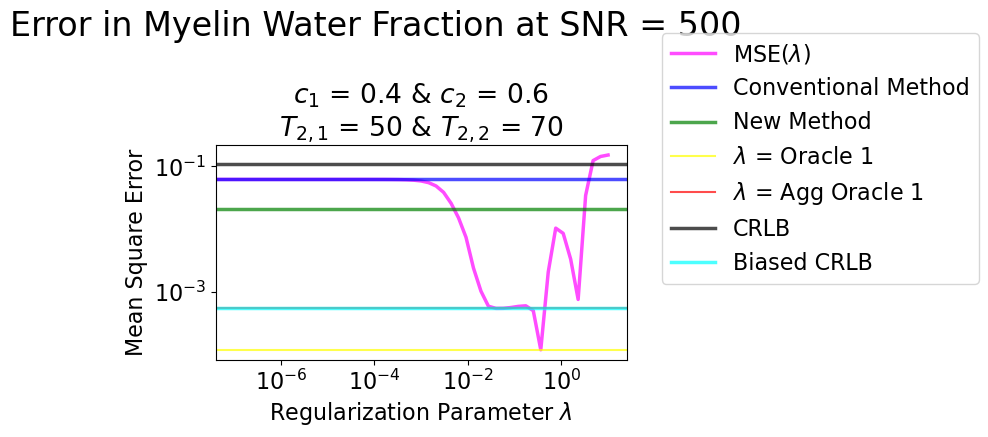

In [42]:
### Official Image for Line Plots

# pCombo_oi = [0.4,0.6,50,70]
# pC_index = paramCombos.index(pCombo_oi)

# single_pC_GCV_MSE = GCV_MSE[pC_index,:]
# single_pC_orcAvg = orcAvg_MSE[pC_index,:,:]
# single_pC_orcAvg_min = np.min(single_pC_orcAvg, axis = 0)
# single_pC_orcErr = minErr_agg_MSE[pC_index,:]
# single_pC_nonReg = nonreg_MSE[pC_index,:]

# CRLB_unbiased = cov_matrix(pCombo_oi[0], pCombo_oi[1], pCombo_oi[2], pCombo_oi[3], SNR_option)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize=(5.5,4.5), tight_layout=True)
plt.rc('font', size = 20)
fig.suptitle(f"Error in Myelin Water Fraction at SNR = {SNR_option}")
plt.rc('font', size = 16)
# fig.suptitle(str(param_name_list) + str(pCombo_oi) + '\nSNR = ' + str(SNR_option) + post_norm_blurb)
ax.loglog(lambdas, single_pC_orcAvg[:,0], label = r'MSE($\lambda$)', alpha = 0.7, color = "magenta", linewidth = 2.5)
ax.axhline(y = single_pC_nonReg[0], label = r'Conventional Method', alpha = 0.7, color = "blue", linewidth = 2.5) #NLLS: $\lambda = 0$
ax.axhline(y = single_pC_GCV_MSE[0], label = r'New Method', alpha = 0.7, color = "green", linewidth = 2.5) #$\lambda = GCV(\lambda)$
ax.axhline(y = single_pC_orcAvg_min[0], label = r'$\lambda$ = Oracle 1', alpha = 0.7, color = "yellow")
ax.axhline(y = single_pC_orcAvg_agg_paramMSE[0], label = r'$\lambda$ = Agg Oracle 1', alpha = 0.7, color = "red")
# ax[i//2, i%2].axhline(y = single_pC_orcErr[i], label = r'$\lambda$ = Oracle 2', alpha = 0.7, color = "orange")
ax.axhline(y = CRLB_unbiased[0,0], label = r'CRLB', alpha = 0.7, color = "black", linewidth = 2.5)
ax.axhline(y = CRLB_biased[0], label = r'Biased CRLB', alpha = 0.7, color = "cyan", linewidth = 2.5)
ax.set_xlabel(r'Regularization Parameter $\lambda$')
ax.set_ylabel('Mean Square Error')
ax.set_title(r'$c_1$' + f' = {pCombo_oi[0]} & ' + r'$c_2$' + f' = {pCombo_oi[1]}\n' + 
                r'$T_{2,1}$' + f' = {pCombo_oi[2]} & ' + r'$T_{2,2}$' + f' = {pCombo_oi[3]}')
handles, labels = ax.get_legend_handles_labels()


# pCombo_oi = [0.4,0.6,30,110]
# pC_index = paramCombos.index(pCombo_oi)

# single_pC_GCV_MSE = GCV_MSE[pC_index,:]
# single_pC_orcAvg = orcAvg_MSE[pC_index,:,:]
# single_pC_orcAvg_min = np.min(single_pC_orcAvg, axis = 0)
# single_pC_orcErr = minErr_agg_MSE[pC_index,:]
# single_pC_nonReg = nonreg_MSE[pC_index,:]

# CRLB_unbiased = cov_matrix(pCombo_oi[0], pCombo_oi[1], pCombo_oi[2], pCombo_oi[3], SNR_option)

# ax[1].loglog(lambdas, single_pC_orcAvg[:,0], label = r'MSE($\lambda$)', alpha = 0.7, color = "magenta")
# ax[1].axhline(y = single_pC_nonReg[0], label = r'NR', alpha = 0.7, color = "blue") #NLLS: $\lambda = 0$
# ax[1].axhline(y = single_pC_GCV_MSE[0], label = r'GCV', alpha = 0.7, color = "green") #$\lambda = GCV(\lambda)$
# # ax[i//2, i%2].axhline(y = single_pC_orcAvg_min[i], label = r'$\lambda$ = Oracle 1', alpha = 0.7, color = "red")
# # ax[i//2, i%2].axhline(y = single_pC_orcErr[i], label = r'$\lambda$ = Oracle 2', alpha = 0.7, color = "orange")
# ax[1].axhline(y = CRLB_unbiased[0,0], label = r'CRLB', alpha = 0.7, color = "black")
# ax[1].set_xlabel(r'Regularization Parameter $\lambda$')
# ax[1].set_ylabel('Mean Square Error')
# ax[1].set_title(r'$c_1$' + f' = {pCombo_oi[0]} & ' + r'$c_2$' + f' = {pCombo_oi[1]}\n' + 
#                 r'$T_{2,1}$' + f' = {pCombo_oi[2]} & ' + r'$T_{2,2}$' + f' = {pCombo_oi[3]}')


fig.legend(handles, labels, loc = 'center left', bbox_to_anchor = (1,0.65))
plt.show()

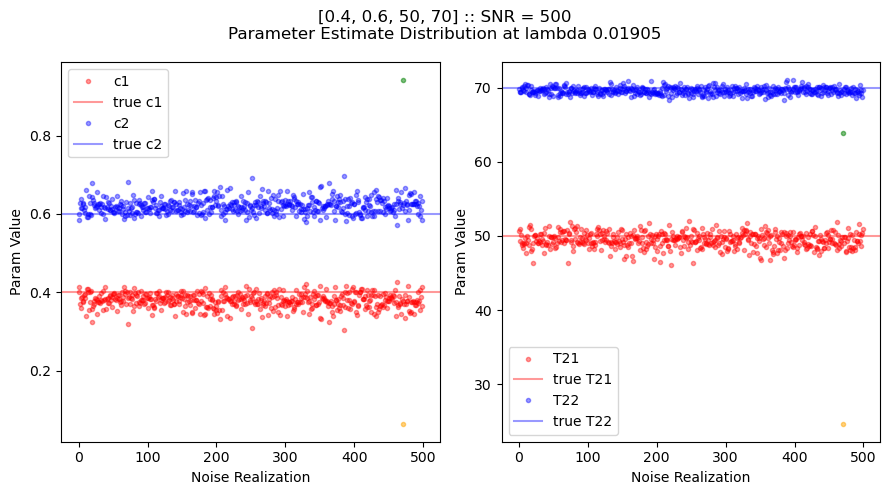

In [19]:
pCombo_oi = [0.4,0.6,50,70]
pC_index = paramCombos.index(pCombo_oi)

lambda_val_oi = np.mean(GCV_lambdas, axis = 1)[pC_index]

lambda_oi = np.argmin((lambdas - lambda_val_oi)**2)

T21_based_out_index = np.where(estimates_rs_ro[pC_index, :, lambda_oi, 2] < pCombo_oi[2]//2)

T21_based_in_index = np.setdiff1d(np.arange(0,500), T21_based_out_index)

plt.rc('font', size = 10)
fig, ax = plt.subplots(1, 2, figsize=(9,5), tight_layout=True)
fig.suptitle(str(pCombo_oi) + ' :: SNR = ' + str(SNR_option) + f"\nParameter Estimate Distribution at lambda {np.round(lambdas[lambda_oi],5)}" + post_norm_blurb)
ax[0].plot(T21_based_out_index, estimates_rs_ro[pC_index,T21_based_out_index, lambda_oi,0], color = "orange", alpha = 0.5, ls = '', marker = '.')
ax[0].plot(T21_based_out_index, estimates_rs_ro[pC_index,T21_based_out_index, lambda_oi,1], color = "green", alpha = 0.5, ls = '', marker = '.')
ax[0].plot(T21_based_in_index, estimates_rs_ro[pC_index,T21_based_in_index, lambda_oi,0], color = "red", label = "c1", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_oi[0], label = 'true c1', color = "red", alpha = 0.4)
ax[0].plot(T21_based_in_index, estimates_rs_ro[pC_index,T21_based_in_index, lambda_oi,1], color = "blue", label = "c2", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_oi[1], label = 'true c2', color = "blue", alpha = 0.4)
ax[0].set_xlabel("Noise Realization")
ax[0].set_ylabel("Param Value")
ax[0].legend()

ax[1].plot(T21_based_out_index, estimates_rs_ro[pC_index,T21_based_out_index, lambda_oi,2], color = "orange", alpha = 0.5, ls = '', marker = '.')
ax[1].plot(T21_based_out_index, estimates_rs_ro[pC_index,T21_based_out_index, lambda_oi,3], color = "green", alpha = 0.5, ls = '', marker = '.')
ax[1].plot(T21_based_in_index, estimates_rs_ro[pC_index,T21_based_in_index, lambda_oi,2], color = "red", label = "T21", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_oi[2], label = 'true T21', color = "red", alpha = 0.4)
ax[1].plot(T21_based_in_index, estimates_rs_ro[pC_index,T21_based_in_index, lambda_oi,3], color = "blue", label = "T22", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_oi[3], label = 'true T22', color = "blue", alpha = 0.4)
ax[1].set_xlabel("Noise Realization")
ax[1].set_ylabel("Param Value")
ax[1].legend()

#c1 outliers = 14 
#c2 outliers = 14 
#T21 outliers = 13 
#T22 outliers = 13


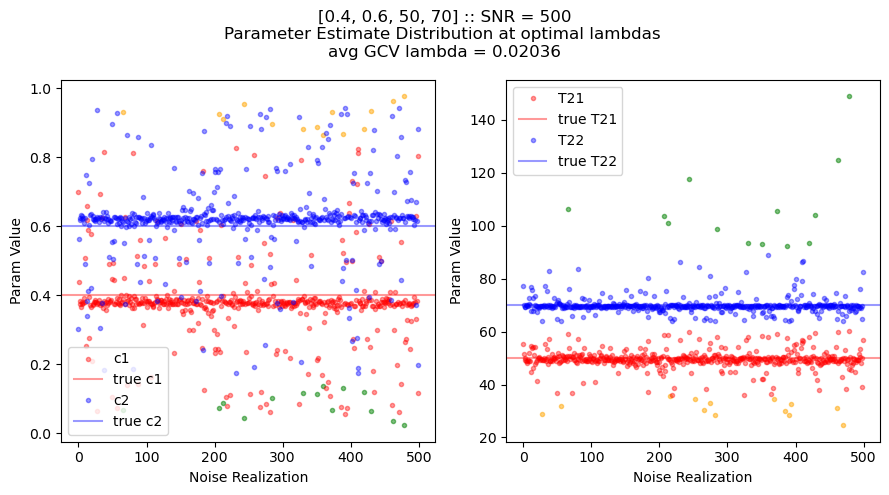

In [20]:
lambda_val_oi = np.mean(GCV_lambdas, axis = 1)[pC_index]

param_means = np.mean(GCV_final_params[pC_index, :], axis = 0)
param_std = np.std(GCV_final_params[pC_index, :], axis = 0)
param_topBar = param_means + 3*param_std
param_lowBar = param_means - 3*param_std

c1_outlier_index = np.array(np.where(np.logical_or(GCV_final_params[pC_index,:,0]<param_lowBar[0],GCV_final_params[pC_index,:,0]>param_topBar[0])))
c2_outlier_index = np.array(np.where(np.logical_or(GCV_final_params[pC_index,:,1]<param_lowBar[1], GCV_final_params[pC_index,:,1]>param_topBar[1])))
T21_outlier_index = np.array(np.where(np.logical_or(GCV_final_params[pC_index,:,2]<param_lowBar[2], GCV_final_params[pC_index,:,2]>param_topBar[2])))
T22_outlier_index = np.array(np.where(np.logical_or(GCV_final_params[pC_index,:,3]<param_lowBar[3], GCV_final_params[pC_index,:,3]>param_topBar[3])))

print(f"#c1 outliers = {np.size(c1_outlier_index)} \n#c2 outliers = {np.size(c2_outlier_index)} \n#T21 outliers = {np.size(T21_outlier_index)} \n#T22 outliers = {np.size(T22_outlier_index)}")

c1_normal_index = np.setdiff1d(np.arange(0,500), c1_outlier_index)
c2_normal_index = np.setdiff1d(np.arange(0,500), c2_outlier_index)
T21_normal_index = np.setdiff1d(np.arange(0,500), T21_outlier_index)
T22_normal_index = np.setdiff1d(np.arange(0,500), T22_outlier_index)

plt.rc('font', size = 10)
fig, ax = plt.subplots(1, 2, figsize=(9,5), tight_layout=True)
fig.suptitle(str(pCombo_oi) + ' :: SNR = ' + str(SNR_option) + f"\nParameter Estimate Distribution at optimal lambdas \navg GCV lambda = {np.round(lambda_val_oi,5)}" + post_norm_blurb)
ax[0].plot(c1_outlier_index, GCV_final_params[pC_index,c1_outlier_index,0], color = "orange", alpha = 0.5, ls = '', marker = '.')
ax[0].plot(c2_outlier_index, GCV_final_params[pC_index,c2_outlier_index,1], color = "green", alpha = 0.5, ls = '', marker = '.')
ax[0].plot(c1_normal_index, GCV_final_params[pC_index,c1_normal_index,0], color = "red", label = "c1", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_oi[0], label = 'true c1', color = "red", alpha = 0.4)
ax[0].plot(c2_normal_index, GCV_final_params[pC_index,c2_normal_index,1], color = "blue", label = "c2", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_oi[1], label = 'true c2', color = "blue", alpha = 0.4)
ax[0].set_xlabel("Noise Realization")
ax[0].set_ylabel("Param Value")
ax[0].legend()

ax[1].plot(T21_outlier_index, GCV_final_params[pC_index,T21_outlier_index,2], color = "orange", alpha = 0.5, ls = '', marker = '.')
ax[1].plot(T22_outlier_index, GCV_final_params[pC_index,T22_outlier_index,3], color = "green", alpha = 0.5, ls = '', marker = '.')
ax[1].plot(T21_normal_index, GCV_final_params[pC_index,T21_normal_index,2], color = "red", label = "T21", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_oi[2], label = 'true T21', color = "red", alpha = 0.4)
ax[1].plot(T22_normal_index, GCV_final_params[pC_index,T22_normal_index,3], color = "blue", label = "T22", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_oi[3], label = 'true T22', color = "blue", alpha = 0.4)
ax[1].set_xlabel("Noise Realization")
ax[1].set_ylabel("Param Value")
ax[1].legend()

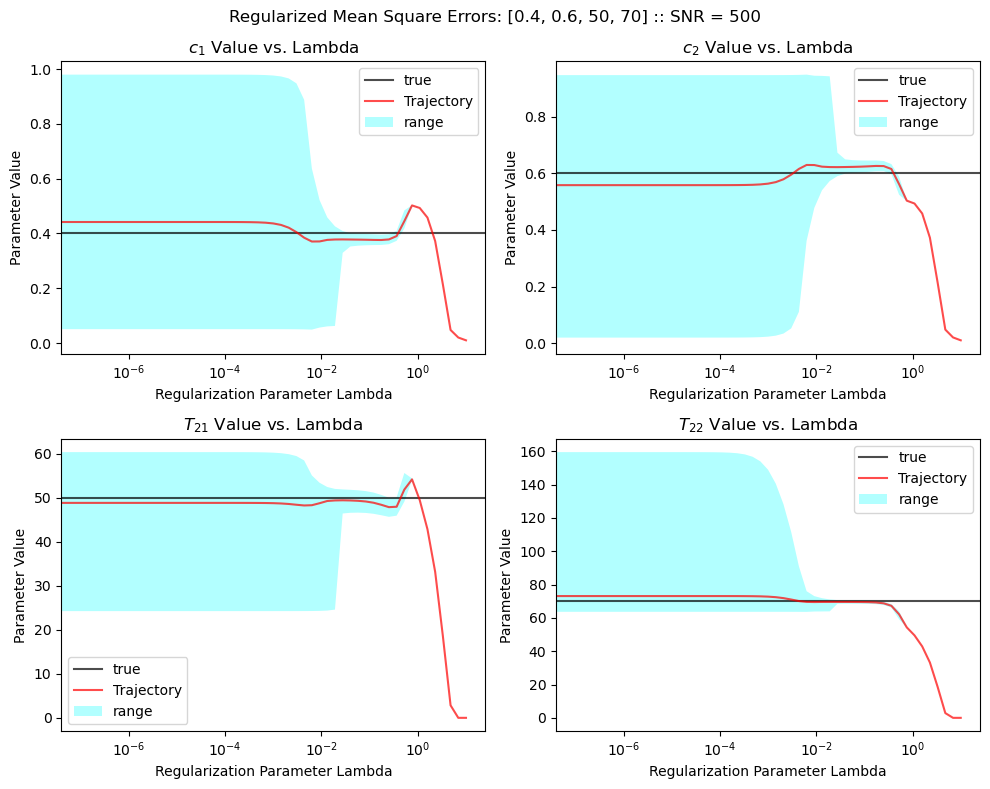

In [21]:
single_meanParam = np.mean(estimates_rs_ro[pC_index,:,:,:], axis = 0)
single_stdParam = np.std(estimates_rs_ro[pC_index,:,:,:], axis = 0)
single_minParam = np.min(estimates_rs_ro[pC_index,:,:,:], axis = 0)
single_maxParam = np.max(estimates_rs_ro[pC_index,:,:,:], axis = 0)

plt.rc('font', size = 10)
fig, ax = plt.subplots(2,2, figsize=(10,8), tight_layout=True)
fig.suptitle('Regularized Mean Square Errors: ' + str(pCombo_oi) + ' :: SNR = ' + str(SNR_option) + post_norm_blurb)
for i in range(4):
    ax[i//2, i%2].axhline(y = pCombo_oi[i], label = "true", alpha = 0.7, color = "black")
    ax[i//2, i%2].semilogx(lambdas, single_meanParam[:,i], label = "Trajectory", alpha = 0.7, color = "red")
    ax[i//2, i%2].fill_between(lambdas, single_minParam[:,i], single_maxParam[:,i], color = 'cyan', alpha = 0.3, lw=0, label = 'range')
    ax[i//2, i%2].set_xlabel('Regularization Parameter Lambda')
    ax[i//2, i%2].set_ylabel('Parameter Value')
    ax[i//2, i%2].set_title(param_name_list[i] + ' Value vs. Lambda')
    ax[i//2, i%2].legend()
plt.show()

In [22]:
check_bias_magnitudes = True
if check_bias_magnitudes:
    pCombo_oi = [0.0,1.0,10,90]
    pC_index = paramCombos.index(pCombo_oi)
    print(pC_index)
    print(nonreg_MSE[pC_index,:])
    print(nonreg_bias[pC_index,:])
    print(nonreg_var[pC_index,:])
    # print(minErr_agg_bias[pC_index,:])


    pCombo_oi = [0.0,1.0,20,90]
    pC_index = paramCombos.index(pCombo_oi)
    print(pC_index)
    print(nonreg_MSE[pC_index,:])
    print(nonreg_bias[pC_index,:])
    print(nonreg_var[pC_index,:])
    # print(minErr_agg_bias[pC_index,:])

1
[2.94248376e-01 2.94069923e-01 3.21513565e+03 6.22722965e+03]
[ 0.32983524 -0.32904088 41.46370303 32.98115952]
[1.85457092e-01 1.85802021e-01 1.49589698e+03 5.13947277e+03]
6
[2.94248376e-01 2.94069923e-01 2.48586159e+03 6.22722965e+03]
[ 0.32983524 -0.32904088 31.46370303 32.98115952]
[1.85457092e-01 1.85802021e-01 1.49589698e+03 5.13947277e+03]


# Show Improvements

In [23]:
#Choose the parameter of interest

POI = 0

##### Oracle 1

In [24]:
if addit_plots:
    if eval_orc_avg:
        #Parameter of interest, using the standard indexing for this code

        size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), 4]

        orcAvg_imp_MSE = np.reshape(orcAvg_imp_MSE,size_array)
        orcAvg_imp_bias_sq = np.reshape(orcAvg_imp_bias_sq,size_array)
        orcAvg_imp_var = np.reshape(orcAvg_imp_var,size_array)
        for c1_VOI in range(size_array[0]):
            fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
            plt.rc('font', size = 10)
            fig.suptitle(f"Oracle 1 {param_name_list[POI]} Improvement over NLLS\nSNR = {SNR_option}\nc1 = {np.round(c1_set[c1_VOI],1)} & c2 = {np.round(1 - c1_set[c1_VOI],1)}" + post_norm_blurb)
            imc1 = ax.imshow(orcAvg_imp_MSE[c1_VOI,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1)

            # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
            ax.set_xticks(np.arange(len(T22_set)))
            ax.set_yticks(np.arange(len(T21_set)))
            ax.set_xticklabels(T22_set)
            ax.set_yticklabels(T21_set)
            ax.set_ylabel(r'$T_{21}$')
            ax.set_xlabel(r'$T_{22}$')

            for i in range(len(T21_set)):
                for j in range(len(T22_set)):
                    MSE_summary = (f"{round(orcAvg_imp_MSE[c1_VOI,i,j,POI], 3)}")
                    if orcAvg_imp_bias_sq[c1_VOI,i,j,POI] < -100 :
                        sq_bias_string = "<-100"
                    else:
                        sq_bias_string = f"{round(orcAvg_imp_bias_sq[c1_VOI,i,j,POI], 3)}"
                    comp_summary = (f"\n{sq_bias_string}\n{round(orcAvg_imp_var[c1_VOI,i,j,POI], 3)}")
                    text = ax.text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
                    text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")

In [25]:
if addit_plots:
    if eval_orc_avg:
        #Parameter of interest, using the standard indexing for this code

        size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), 4]

        minMSE_orcAvg_lamb = np.reshape(minMSE_orcAvg_lamb ,size_array)
        for c1_VOI in range(size_array[0]):
            fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
            fig.suptitle(f"Best Oracle 1 Lambda NLLS, SNR = {SNR_option}\nc1 = {np.round(c1_set[c1_VOI],1)} & c2 = {np.round(1 - c1_set[c1_VOI],1)}" + post_norm_blurb)
            imc1 = ax.imshow(minMSE_orcAvg_lamb[c1_VOI,:,:,POI], cmap = 'Oranges', vmin = -5, vmax = 12)

            ax.set_title('Lambda Value')
            ax.set_xticks(np.arange(len(T22_set)))
            ax.set_yticks(np.arange(len(T21_set)))
            ax.set_xticklabels(T22_set)
            ax.set_yticklabels(T21_set)
            ax.set_ylabel('T21 values')
            ax.set_xlabel('T22 values')

            for i in range(len(T21_set)):
                for j in range(len(T22_set)):
                    lamb_summary = (f"{round(minMSE_orcAvg_lamb[c1_VOI,i,j, POI], 4)}")
                    text = ax.text(j, i, lamb_summary, ha="center", va="center", color="black", weight = "bold")

##### ORacle 2

In [26]:
if addit_plots:
    if eval_minErr:
        #Parameter of interest, using the standard indexing for this code

        size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), 4]

        minErr_agg_imp_MSE = np.reshape(minErr_agg_imp_MSE,size_array)
        minErr_agg_imp_bias_sq = np.reshape(minErr_agg_imp_bias_sq,np.abs(size_array))
        minErr_agg_imp_var = np.reshape(minErr_agg_imp_var,size_array)
        for c1_VOI in range(size_array[0]):
            fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
            plt.rc('font', size = 10)
            fig.suptitle(f"Oracle 2 {param_name_list[POI]} Improvement over NLLS\nSNR = {SNR_option}\nc1 = {np.round(c1_set[c1_VOI],1)} & c2 = {np.round(1 - c1_set[c1_VOI],1)}" + post_norm_blurb)
            imc1 = ax.imshow(minErr_agg_imp_MSE[c1_VOI,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1)

            # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
            ax.set_xticks(np.arange(len(T22_set)))
            ax.set_yticks(np.arange(len(T21_set)))
            ax.set_xticklabels(T22_set)
            ax.set_yticklabels(T21_set)
            ax.set_ylabel(r'$T_{21}$')
            ax.set_xlabel(r'$T_{22}$')

            for i in range(len(T21_set)):
                for j in range(len(T22_set)):
                    MSE_summary = (f"{round(minErr_agg_imp_MSE[c1_VOI,i,j,POI], 3)}")
                    if minErr_agg_imp_bias_sq[c1_VOI,i,j,POI] < -100 :
                        sq_bias_string = "<-100"
                    else:
                        sq_bias_string = f"{round(minErr_agg_imp_bias_sq[c1_VOI,i,j,POI], 3)}"
                    comp_summary = (f"\n{sq_bias_string}\n{round(minErr_agg_imp_var[c1_VOI,i,j,POI], 3)}")
                    text = ax.text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
                    text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")

In [27]:
if addit_plots:
    if eval_minErr:
        #Parameter of interest, using the standard indexing for this code

        size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set)]

        avg_lambda = np.mean(minErr_orcNR_agg_lamb, axis = -1)
        std_lambda = np.std(minErr_orcNR_agg_lamb, axis = -1)

        avg_minErr_agg_lamb = np.reshape(avg_lambda, size_array)
        std_minErr_agg_lamb = np.reshape(std_lambda, size_array)
        for c1_VOI in range(size_array[0]):
            fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
            fig.suptitle(f"Best Oracle 1 Lambda NLLS, SNR = {SNR_option}\nc1 = {np.round(c1_set[c1_VOI],1)} & c2 = {np.round(1 - c1_set[c1_VOI],1)}" + post_norm_blurb)
            imc1 = ax.imshow(avg_minErr_agg_lamb[c1_VOI,:,:], cmap = 'Oranges', vmin = -5, vmax = 10)

            ax.set_title('Lambda Value')
            ax.set_xticks(np.arange(len(T22_set)))
            ax.set_yticks(np.arange(len(T21_set)))
            ax.set_xticklabels(T22_set)
            ax.set_yticklabels(T21_set)
            ax.set_ylabel('T21 values')
            ax.set_xlabel('T22 values')

            for i in range(len(T21_set)):
                for j in range(len(T22_set)):
                    lamb_summary = (f"{round(avg_minErr_agg_lamb[c1_VOI,i,j], 4)}")
                    lamb_std = (f"{round(std_minErr_agg_lamb[c1_VOI,i,j], 4)}")
                    text = ax.text(j, i - 0.2, lamb_summary, ha="center", va="center", color="black", weight = "bold")
                    text2 = ax.text(j, i, lamb_std, ha="center", va="center", color="black")

##### GCV

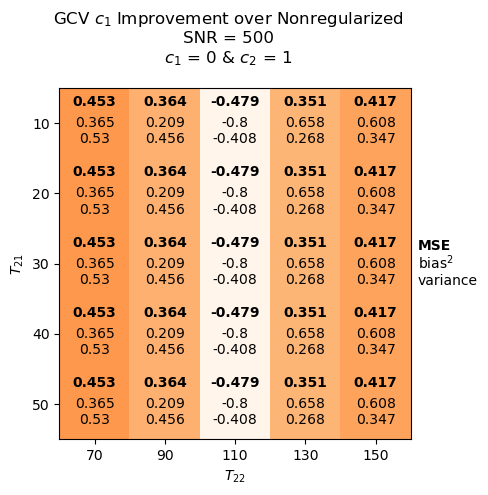

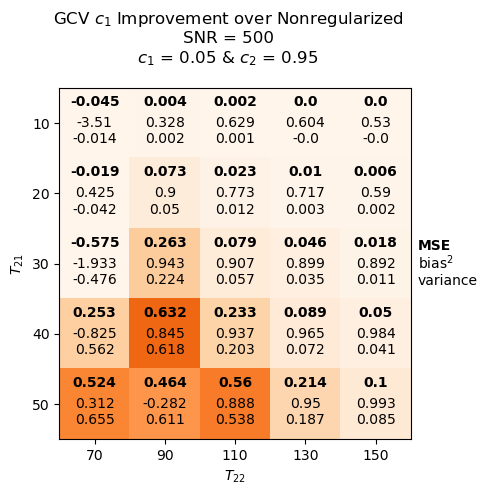

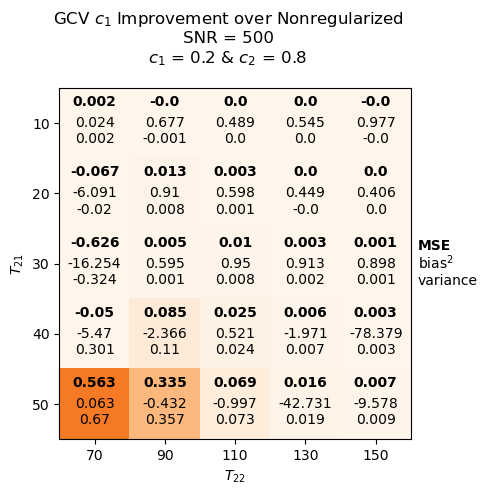

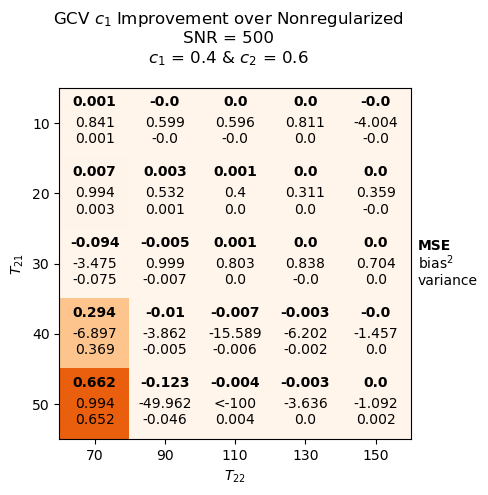

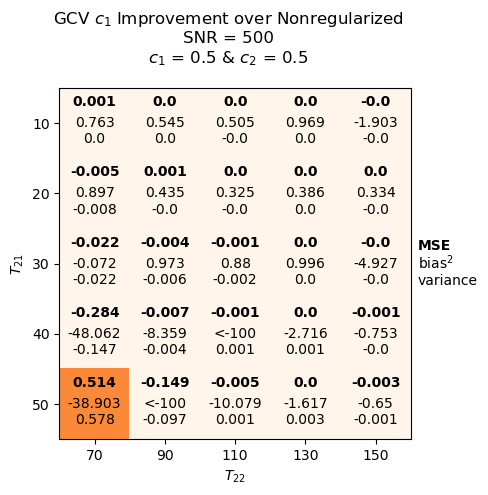

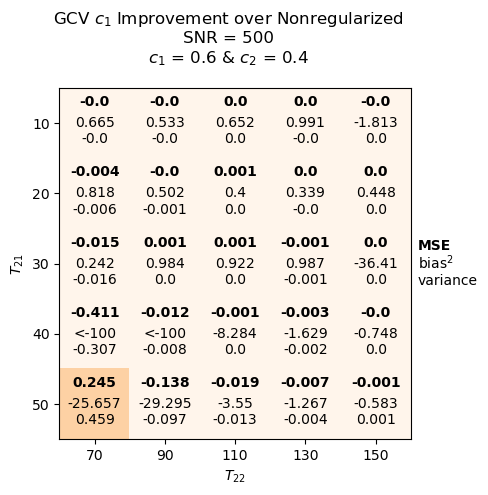

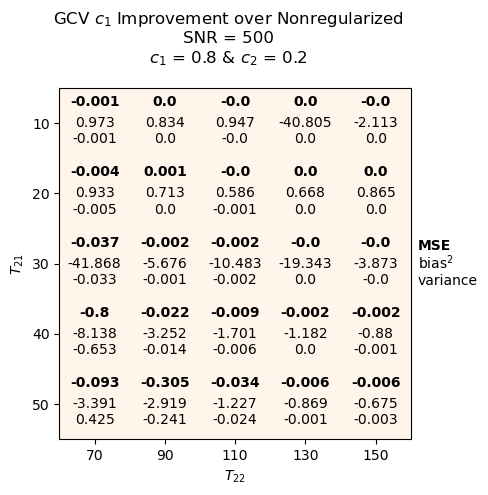

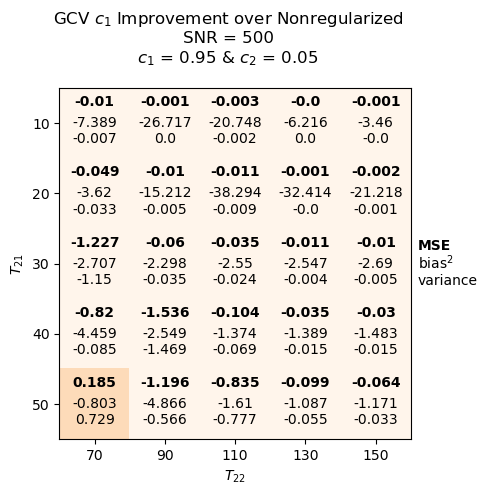

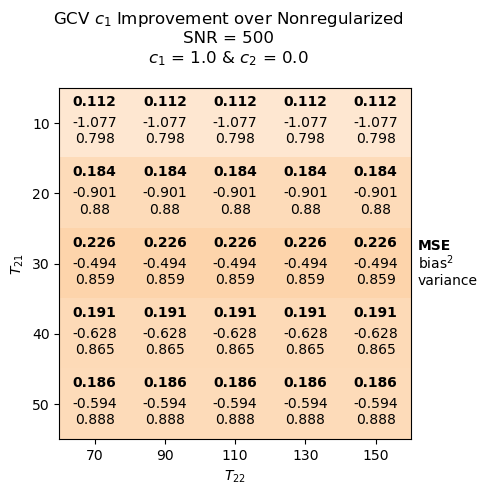

In [28]:
if eval_GCV:
    #Parameter of interest, using the standard indexing for this code
    print(post_norm_blurb)

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), 4]

    GCV_imp_MSE = np.reshape(GCV_imp_MSE,size_array)
    GCV_imp_bias_sq = np.reshape(GCV_imp_bias_sq,size_array)
    GCV_imp_var = np.reshape(GCV_imp_var,size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        fig.suptitle(f"GCV {param_name_list[POI]} Improvement over Nonregularized\nSNR = {SNR_option}\n" + r'$c_1$' + f" = {np.round(c1_set[c1_VOI],2)} & " + r'$c_2$' + f" = {np.round(1 - c1_set[c1_VOI],2)}")
        imc1 = ax.imshow(GCV_imp_MSE[c1_VOI,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1)

        # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel(r'$T_{21}$')
        ax.set_xlabel(r'$T_{22}$')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                MSE_summary = (f"{round(GCV_imp_MSE[c1_VOI,i,j,POI], 3)}")
                if GCV_imp_bias_sq[c1_VOI,i,j,POI] < -100 :
                    sq_bias_string = "<-100"
                else:
                    sq_bias_string = f"{round(GCV_imp_bias_sq[c1_VOI,i,j,POI], 3)}"
                comp_summary = (f"\n{sq_bias_string}\n{round(GCV_imp_var[c1_VOI,i,j,POI], 3)}")
                text = ax.text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")
        text = fig.text(0.88, 0.50, 'MSE', color="black", weight = "bold", transform = plt.gcf().transFigure)
        text2 = fig.text(0.88, 0.43, r'bias$^2$' + '\nvariance', color="black", transform = plt.gcf().transFigure)


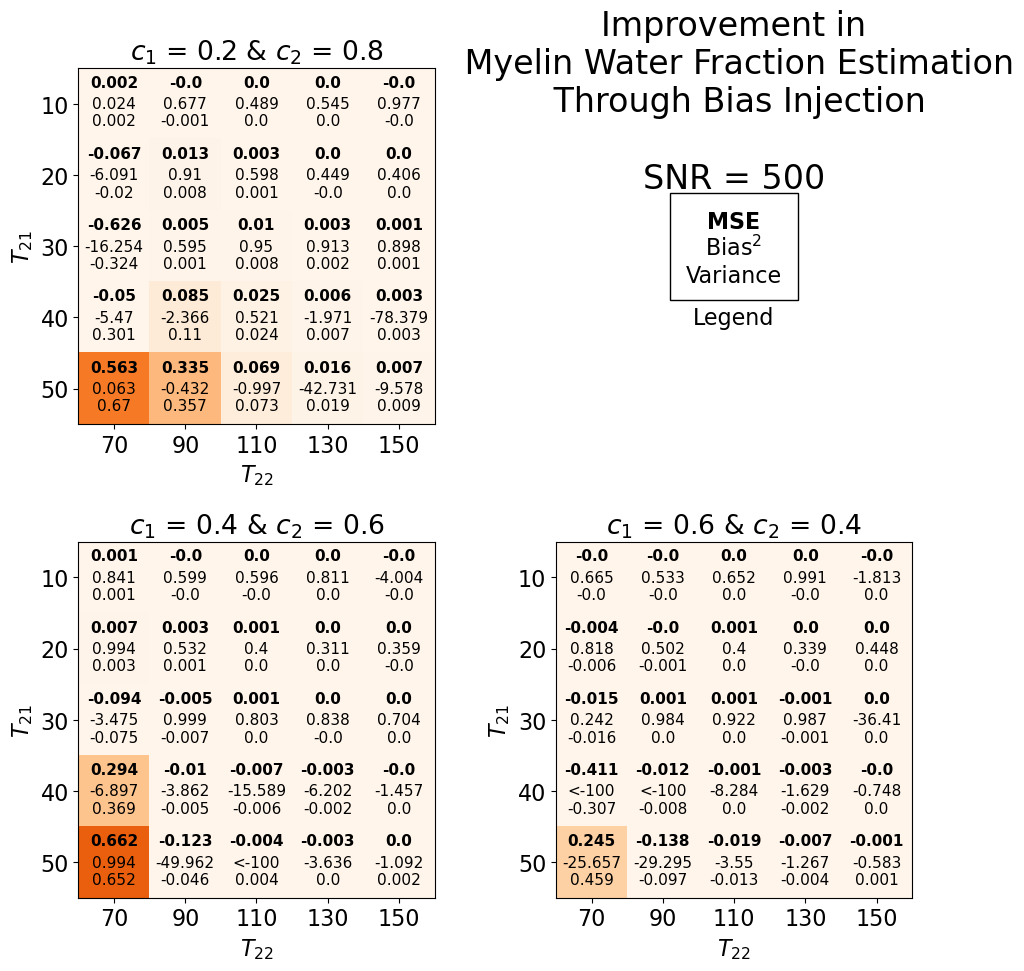

In [29]:
### Official Figure for Improvement

if eval_GCV:
    #Parameter of interest, using the standard indexing for this code
    print(post_norm_blurb)

    def gen_patchwork_panel(ind_x, ind_y, c1_COI, var_temp, sq_bias_temp, MSE_temp):
        ######## bottom left
        plt.rc('font', size = 16)
        ax[ind_x, ind_y].set_title(r'$c_1$' + f" = {np.round(c1_set[c1_COI],2)} & " + r'$c_2$' + f" = {np.round(1 - c1_set[c1_COI],2)}")
        imc1 = ax[ind_x, ind_y].imshow(MSE_temp[c1_COI,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1)

        # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
        ax[ind_x, ind_y].set_xticks(np.arange(len(T22_set)))
        ax[ind_x, ind_y].set_yticks(np.arange(len(T21_set)))
        ax[ind_x, ind_y].set_xticklabels(T22_set)
        ax[ind_x, ind_y].set_yticklabels(T21_set)
        ax[ind_x, ind_y].set_ylabel(r'$T_{21}$')
        ax[ind_x, ind_y].set_xlabel(r'$T_{22}$')

        plt.rc('font', size = 11)
        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                MSE_summary = (f"{round(MSE_temp[c1_COI,i,j,POI], 3)}")
                if sq_bias_temp[c1_COI,i,j,POI] < -100 :
                    sq_bias_string = "<-100"
                else:
                    sq_bias_string = f"{round(sq_bias_temp[c1_COI,i,j,POI], 3)}"
                comp_summary = (f"\n{sq_bias_string}\n{round(var_temp[c1_COI,i,j,POI], 3)}")
                text = ax[ind_x, ind_y].text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax[ind_x, ind_y].text(j, i, comp_summary, ha="center", va="center", color="black")

        return

    c1_combos_oi = [2,3,5]
    x_patches = [0,1,1]
    y_patches = [0,0,1]

    
    plt.rc('font', size = 16)
    fig, ax = plt.subplots(2,2, figsize = (10, 10), tight_layout=True)
    
    for ii in range(3):
        gen_patchwork_panel(x_patches[ii], y_patches[ii], c1_combos_oi[ii], GCV_imp_var, GCV_imp_bias_sq, GCV_imp_MSE)

    plt.rc('font', size = 20)
    ax[0,1].axis('off')
    ax[0,1].set_title(f"Improvement in\n Myelin Water Fraction Estimation\n Through Bias Injection\n\nSNR = {SNR_option}", y = 0.8, pad = -35)

    plt.rc('font', size = 16)
    rect = mpl.patches.Rectangle((0.35,0.35), 0.3, 0.3, linewidth = 1, edgecolor = 'k', facecolor = 'none')
    ax[0,1].add_patch(rect)
    text = ax[0,1].text(0.5, 0.55, 'MSE', color="black", weight = "bold", ha = 'center')
    text2 = ax[0,1].text(0.5, 0.40, r'Bias$^2$' + '\nVariance', color="black", ha = 'center')
    text3 = ax[0,1].text(0.5, 0.28, 'Legend', color="black", ha = 'center')
        

In [30]:
if addit_plots:
    if eval_GCV:
        #Parameter of interest, using the standard indexing for this code

        size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set)]

        GCV_lambdas_mean = np.reshape(np.mean(GCV_lambdas, axis = 1), size_array)
        GCV_lambdas_min = np.reshape(np.min(GCV_lambdas, axis = 1), size_array)
        GCV_lambdas_max = np.reshape(np.max(GCV_lambdas, axis = 1), size_array)
        for c1_VOI in range(size_array[0]):
            fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
            fig.suptitle(f"GCV Lambda NLLS, SNR = {SNR_option}\nc1 = {np.round(c1_set[c1_VOI],1)} & c2 = {np.round(1 - c1_set[c1_VOI],1)}" + post_norm_blurb)
            imc1 = ax.imshow(GCV_lambdas_mean[c1_VOI,:,:], cmap = 'Oranges', vmin = 0, vmax = 1.2)

            ax.set_title('Lambda Value')
            ax.set_xticks(np.arange(len(T22_set)))
            ax.set_yticks(np.arange(len(T21_set)))
            ax.set_xticklabels(T22_set)
            ax.set_yticklabels(T21_set)
            ax.set_ylabel('T21 values')
            ax.set_xlabel('T22 values')

            for i in range(len(T21_set)):
                for j in range(len(T22_set)):
                    lamb_summary = (f"{round(GCV_lambdas_mean[c1_VOI,i,j], 3)}")
                    comp_summary = (f"\n{round(GCV_lambdas_max[c1_VOI,i,j], 3)}\n{round(GCV_lambdas_min[c1_VOI,i,j], 3)}")
                    text = ax.text(j, i-0.3, lamb_summary, ha="center", va="center", color="black", weight = "bold")
                    text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")

### Improvements for Aggregate Measures

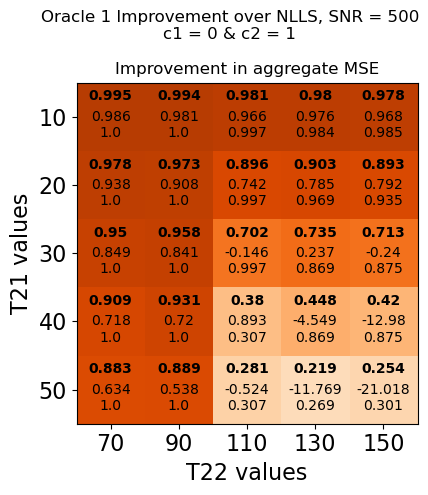

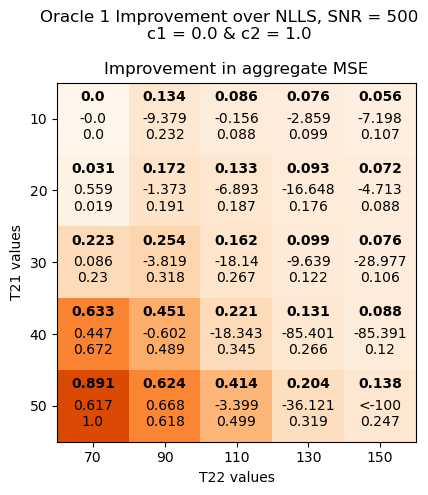

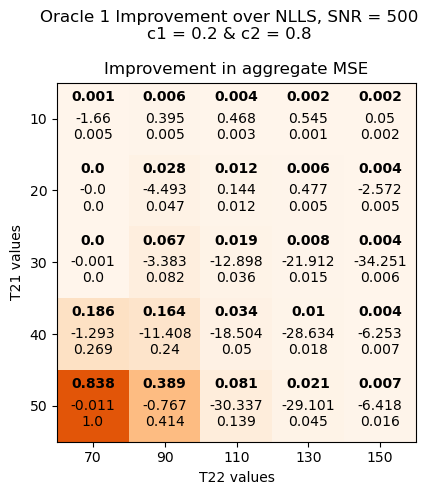

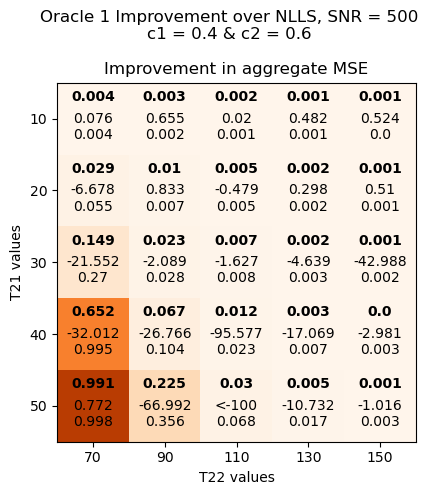

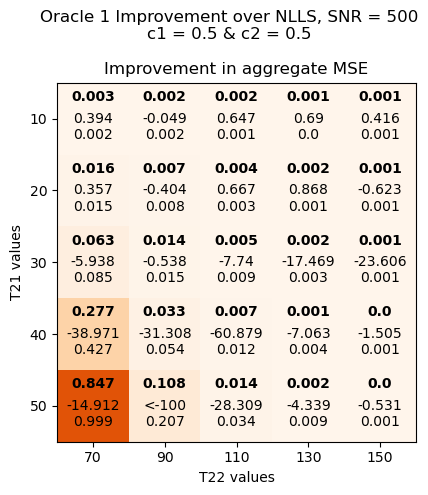

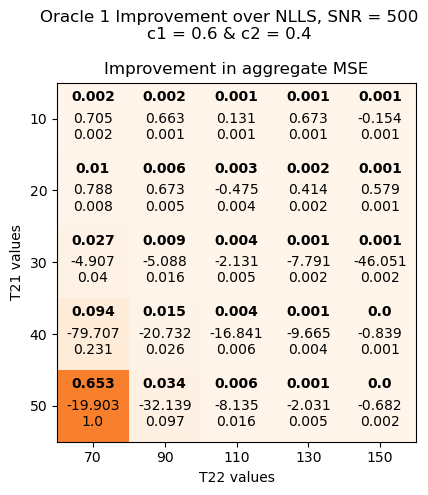

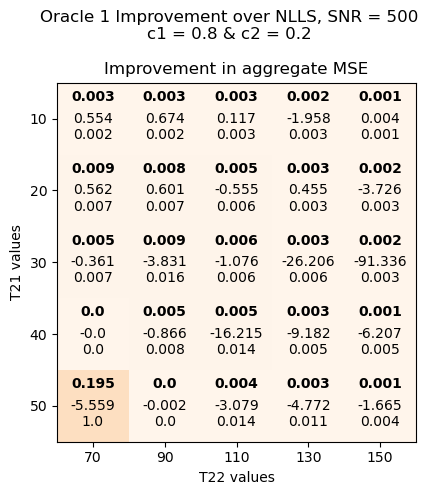

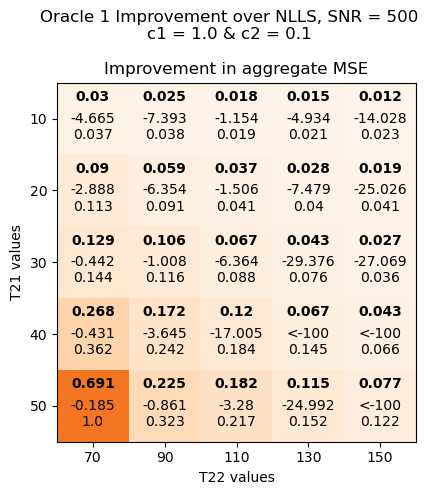

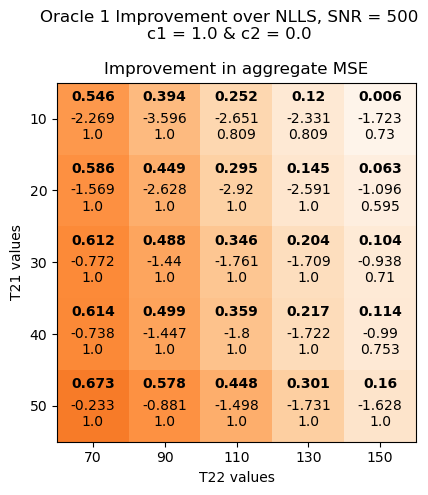

In [31]:
if eval_orc_avg:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set)]

    orcAvg_agg_imp_MSE = np.reshape(orcAvg_agg_imp_MSE,size_array)
    orcAvg_agg_imp_bias_sq = np.reshape(orcAvg_agg_imp_bias_sq,size_array)
    orcAvg_agg_imp_var = np.reshape(orcAvg_agg_imp_var,size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        plt.rc('font', size = 10)
        fig.suptitle(f"Oracle 1 Improvement over NLLS, SNR = {SNR_option}\nc1 = {np.round(c1_set[c1_VOI],1)} & c2 = {np.round(1 - c1_set[c1_VOI],1)}" + post_norm_blurb)
        imc1 = ax.imshow(orcAvg_agg_imp_MSE[c1_VOI,:,:], cmap = 'Oranges', vmin = 0, vmax = 1.2)

        ax.set_title('Improvement in aggregate MSE')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                MSE_summary = (f"{round(orcAvg_agg_imp_MSE[c1_VOI,i,j], 3)}")
                if orcAvg_agg_imp_bias_sq[c1_VOI,i,j] < -100 :
                    sq_bias_string = "<-100"
                else:
                    sq_bias_string = f"{round(orcAvg_agg_imp_bias_sq[c1_VOI,i,j], 3)}"
                comp_summary = (f"\n{sq_bias_string}\n{round(orcAvg_agg_imp_var[c1_VOI,i,j], 3)}")
                text = ax.text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")

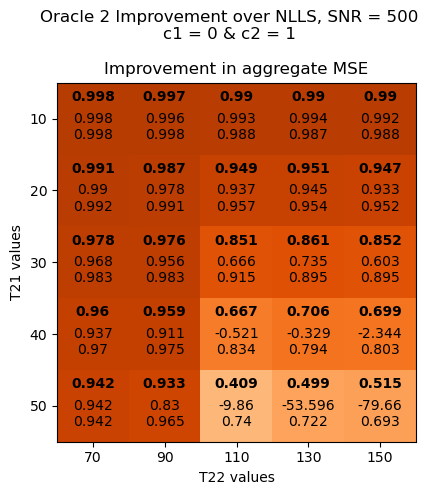

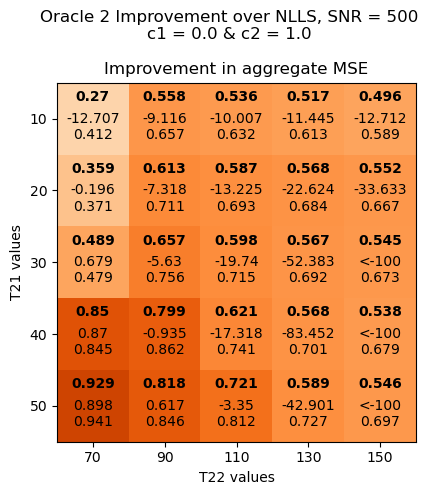

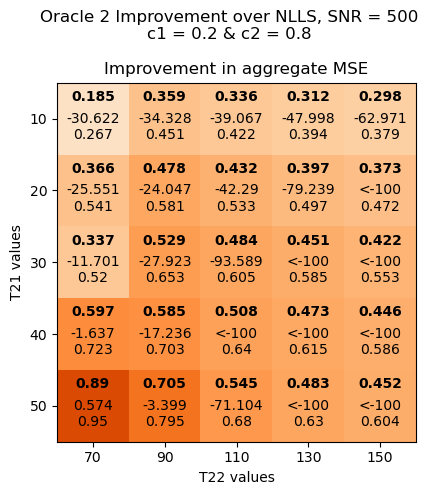

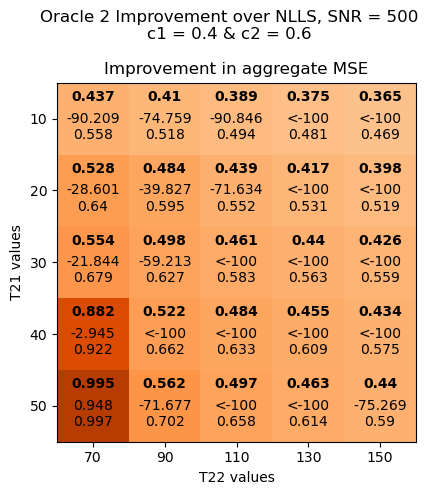

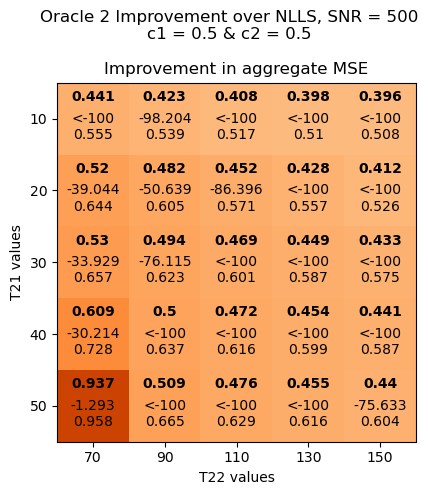

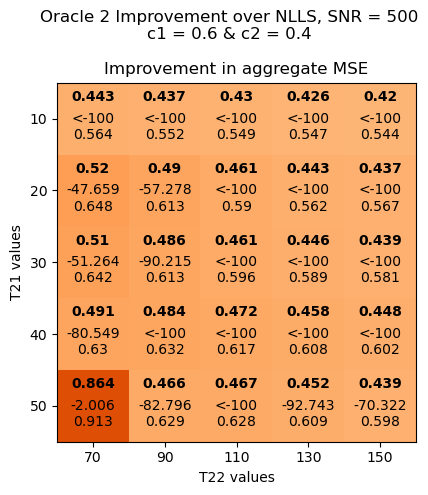

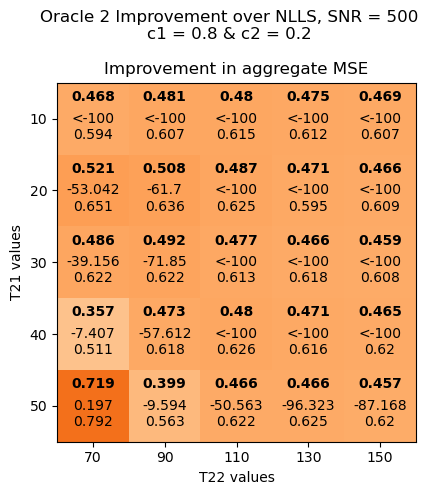

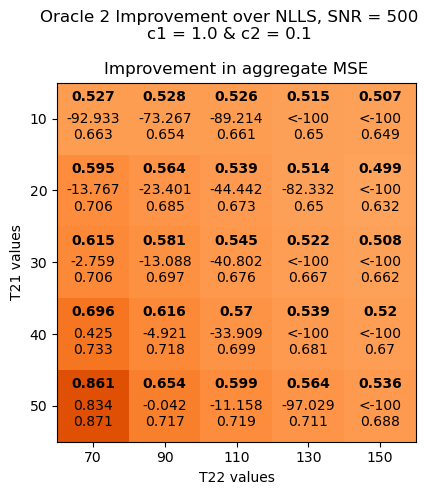

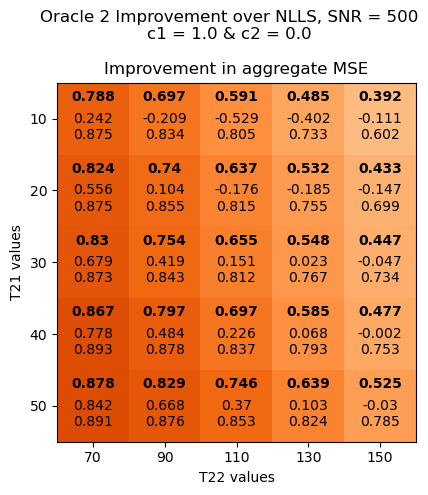

In [32]:
if eval_minErr:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set)]

    POI = 0
    minErr_agg_imp_MSE_agg = np.reshape(minErr_agg_imp_MSE_agg,size_array)
    minErr_agg_imp_bias_sq_agg = np.reshape(minErr_agg_imp_bias_sq_agg,np.abs(size_array))
    minErr_agg_imp_var_agg = np.reshape(minErr_agg_imp_var_agg,size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        plt.rc('font', size = 10)
        fig.suptitle(f"Oracle 2 Improvement over NLLS, SNR = {SNR_option}\nc1 = {np.round(c1_set[c1_VOI],1)} & c2 = {np.round(1 - c1_set[c1_VOI],1)}" + post_norm_blurb)
        imc1 = ax.imshow(minErr_agg_imp_MSE_agg[c1_VOI,:,:], cmap = 'Oranges', vmin = 0, vmax = 1.2)

        ax.set_title('Improvement in aggregate MSE')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                MSE_summary = (f"{round(minErr_agg_imp_MSE_agg[c1_VOI,i,j], 3)}")
                if minErr_agg_imp_bias_sq_agg[c1_VOI,i,j] < -100 :
                    sq_bias_string = "<-100"
                else:
                    sq_bias_string = f"{round(minErr_agg_imp_bias_sq_agg[c1_VOI,i,j], 3)}"
                comp_summary = (f"\n{sq_bias_string}\n{round(minErr_agg_imp_var_agg[c1_VOI,i,j], 3)}")
                text = ax.text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")

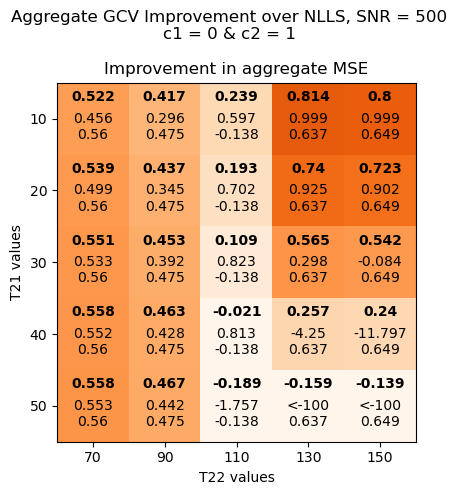

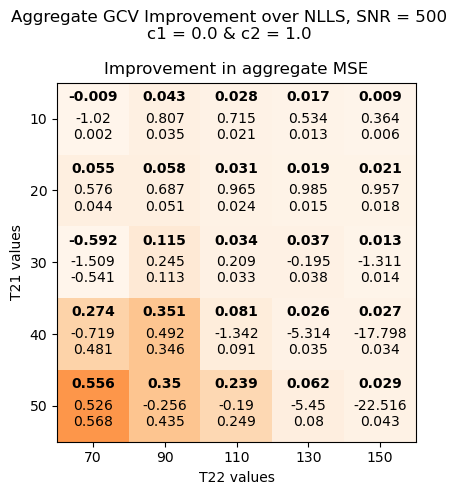

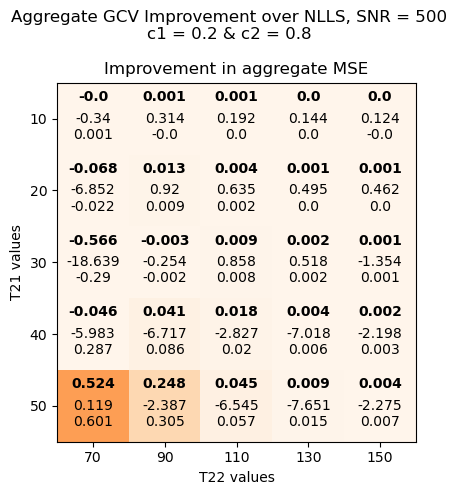

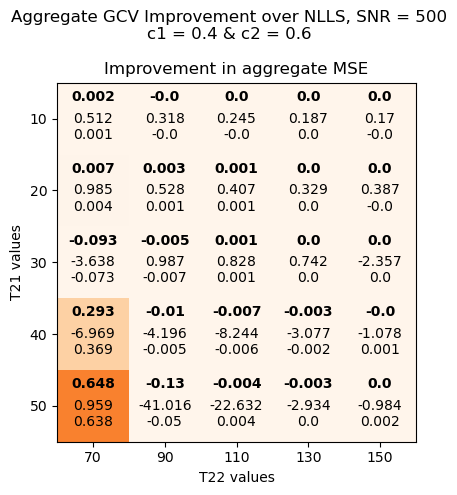

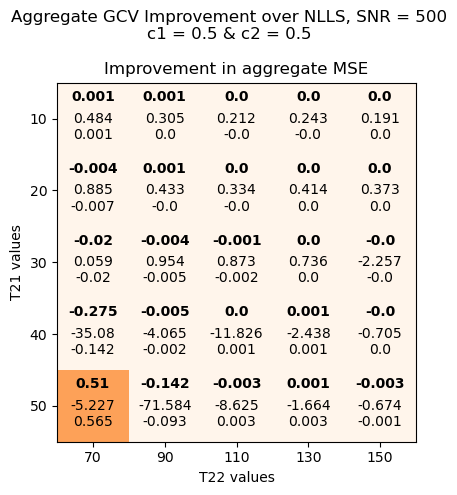

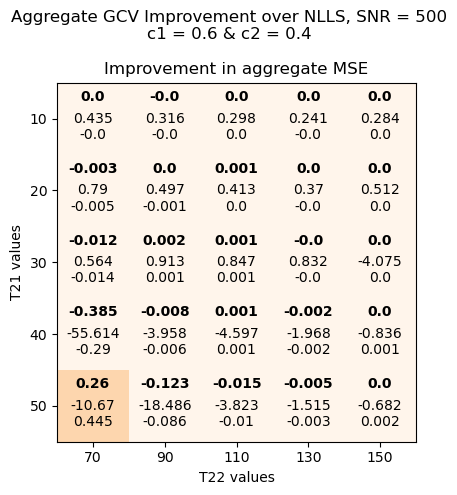

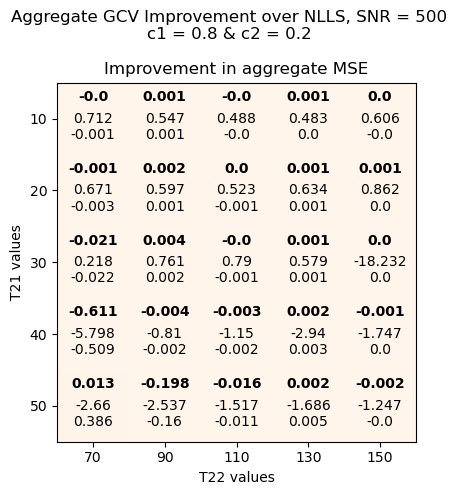

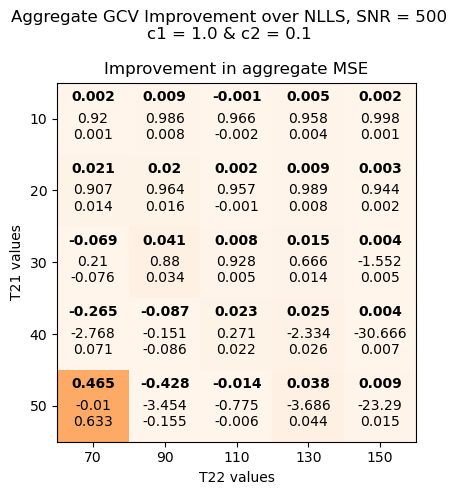

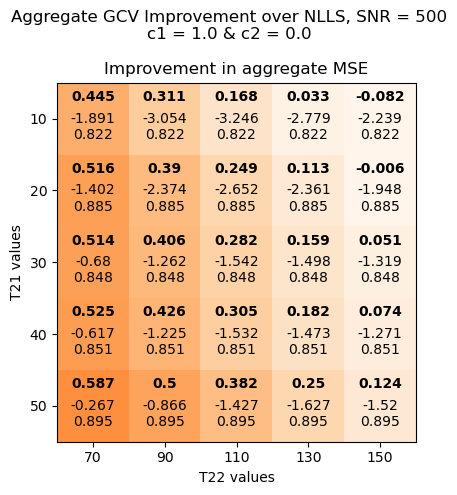

In [33]:
if eval_GCV:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set)]

    POI = 0
    GCV_agg_imp_MSE = np.reshape(GCV_agg_imp_MSE,size_array)
    GCV_agg_imp_bias_sq = np.reshape(GCV_agg_imp_bias_sq,size_array)
    GCV_agg_imp_var = np.reshape(GCV_agg_imp_var,size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        fig.suptitle(f"Aggregate GCV Improvement over NLLS, SNR = {SNR_option}\nc1 = {np.round(c1_set[c1_VOI],1)} & c2 = {np.round(1 - c1_set[c1_VOI],1)}" + post_norm_blurb)
        imc1 = ax.imshow(GCV_agg_imp_MSE[c1_VOI,:,:], cmap = 'Oranges', vmin = 0, vmax = 1.2)

        ax.set_title('Improvement in aggregate MSE')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                MSE_summary = (f"{round(GCV_agg_imp_MSE[c1_VOI,i,j], 3)}")
                if GCV_agg_imp_bias_sq[c1_VOI,i,j] < -100 :
                    sq_bias_string = "<-100"
                else:
                    sq_bias_string = f"{round(GCV_agg_imp_bias_sq[c1_VOI,i,j], 3)}"
                comp_summary = (f"\n{sq_bias_string}\n{round(GCV_agg_imp_var[c1_VOI,i,j], 3)}")
                text = ax.text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")
